In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")
image_path = './data/mnist/train'
batch_size = 64
z_size = 100
image_size = (28, 28)
n_filters = 32 

In [2]:
import numpy as np
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)


mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True, num_workers=20)



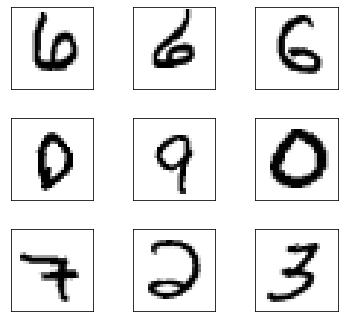

In [3]:
#show some images
from utils_gen import plot_images
plot_images(mnist_dl)

In [4]:
from generators import Generator, Discriminator
from utils_gen import Trainner
trainer = Trainner(Generator(), Discriminator(), mnist_dl, device)
trainer.train_both(epochs=50, train_gen_every=1, train_dis_every=1)

  0%|          | 0/46850 [00:00<?, ?it/s]

Epoch: 0 - D loss: 0.1281745582818985 - G loss: 5.673701763153076
Epoch: 1 - D loss: 0.023356107994914055 - G loss: 7.567143440246582
Epoch: 2 - D loss: 0.28147637844085693 - G loss: 3.3962607383728027
Epoch: 3 - D loss: 0.3148658275604248 - G loss: 2.8137059211730957
Epoch: 4 - D loss: 0.2334163337945938 - G loss: 1.6193046569824219
Epoch: 5 - D loss: 0.20934724807739258 - G loss: 3.8352346420288086
Epoch: 6 - D loss: 0.49532350897789 - G loss: 3.6882972717285156
Epoch: 7 - D loss: 0.4277184307575226 - G loss: 2.1606900691986084
Epoch: 8 - D loss: 0.599466860294342 - G loss: 2.3172645568847656
Epoch: 9 - D loss: 0.3826936185359955 - G loss: 2.7551162242889404
Epoch: 10 - D loss: 0.3651900291442871 - G loss: 1.4988484382629395
Epoch: 11 - D loss: 0.6453351378440857 - G loss: 3.4844136238098145
Epoch: 12 - D loss: 0.2041524350643158 - G loss: 3.8006045818328857
Epoch: 13 - D loss: 0.432201087474823 - G loss: 4.296591758728027
Epoch: 14 - D loss: 0.17391860485076904 - G loss: 2.731561422

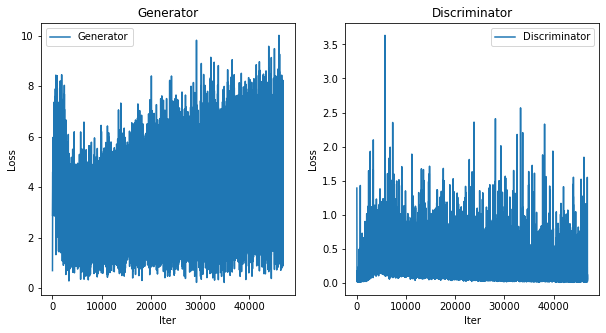

In [17]:
from utils_gen import plot_losses
plot_losses(trainer)

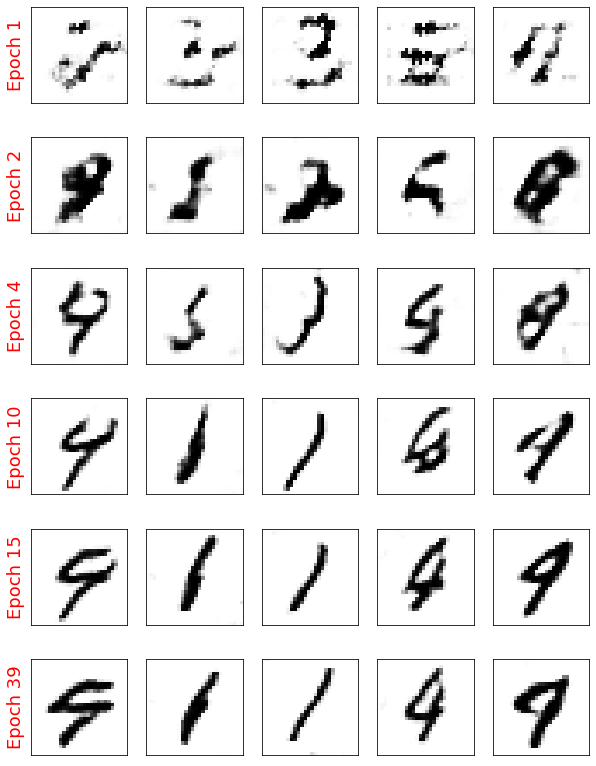

In [55]:
from utils_gen import plot_epochs_images
plot_epochs_images(trainer.epoch_samples)

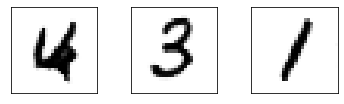

In [54]:
from utils_gen import generate_and_show
generate_and_show(trainer.generator, device)

ValueError: num must be 1 <= num <= 50, not 51

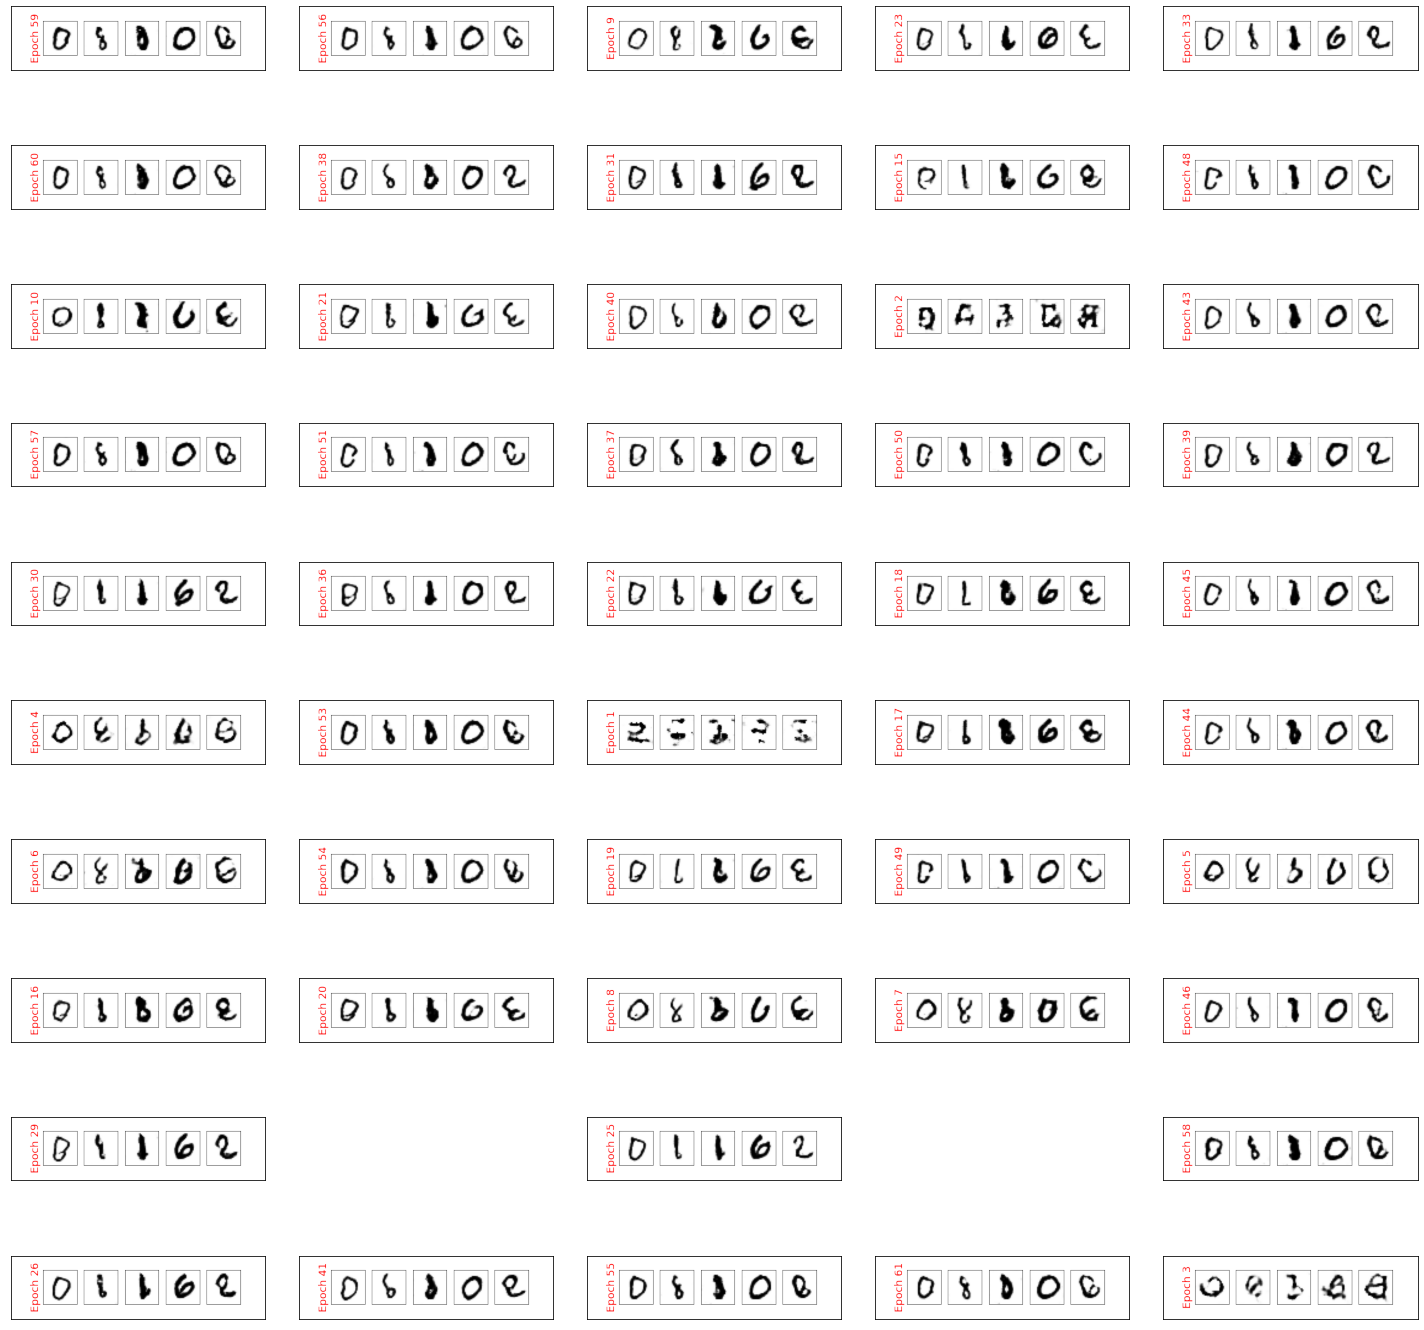

In [67]:
#list all files in figures directory
import os
images_names = os.listdir('figures')

#Load images in images_names using PIL
import PIL
images = [PIL.Image.open(f'figures/{name}') for name in images_names]

#show images using matplotlib one on top of another
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i, image in enumerate(images):
    plt.subplot(10, 5, i+1)
    plt.tight_layout()
    plt.imshow(image, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])